## TO DO ASAP: 

### Explain how the interactive plot works, using as examples the two from [here](https://github.com/mycarta/Data-science-tools-petroleum-exploration-and-production/blob/master/Python/notebooks/Python_data_science_tools%20_petroleum_exploration_production.ipynb)

### Give credit to Christian Mogensen for the original idea / presentation on Excel tool when working at DONG Energy

#### Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib as mpl
import seaborn as sns
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import rc
font = {'size'   : 18}
rc('font', **font)

In [3]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

#### Helper functions

##### Confidence interval for the correlation coefficient

In [4]:
def confInt(r, nwells):
    """Function to calculate calculates the confidence interval interval for the population
    correlation coefficient  (P97.5 and P2.5), given a confidence level of 95%, the number of
    wells (and from that the degrees of freedom), and the sample correlation coefficient.
    For the details of the calculation, see Brown at: http://brownmath.com/stat/correl.htm#CI
    Notice that the function can take directly arrays as parameters (broadcasting)"""
    z_crit = stats.norm.ppf(.975)
    std_Z = 1/np.sqrt(nwells-3)
    E = z_crit*std_Z
    Z_star = 0.5*(np.log((1+r)/(1.0000000000001-r)))
    ZCI_l = Z_star - E
    ZCI_u = Z_star + E
    RCI_l = (np.exp(2*ZCI_l)-1)/(np.exp(2*ZCI_l)+1)
    RCI_u = (np.exp(2*ZCI_u)-1)/(np.exp(2*ZCI_u)+1)
    return RCI_u, RCI_l

##### Critical r test

In [5]:
def r_crit(nwells, a=0.05):
    """Function to calculate the value of critical correlation coefficient: 
    that is, the value of the correlation coefficient at which you can rule out chance as 
    an explanation for the relationship in the sample.
    # a is equal to alpha/2, where alpha is the level of significance,
    # the complement of the confidence level; default = 0.05"""
    
    t = stats.t.isf(a, nwells-2) # nwells-2 is the degrees of freedom
    r_crit = t/np.sqrt((nwells-2)+ np.power(t,2))
    return float("{0:.1f}".format(r_crit))

#### Define the function to do all the interactive plotting and also output array

In [6]:
def conf_int_demo(r, nwells):
    """This makes an interactive figure where the parameters...
    ..."""

    # set up variables
    crr = np.arange(0.0,1.02,0.02).round(decimals=2)
    cm = np.asarray(confInt(crr, nwells))
    cm_test = np.asarray(confInt(r, nwells))

    # set up figure
    fig, ax = plt.subplots(figsize=(12,15))
    plt.title('Confidence interval for correlation coefficient' + str(nwells) + ' wells')
    ax.set_ylim([-1.05,1.05])
    ax.set_xlim([0, 1])
    ax.set_ylabel('R', rotation = 0)
    ax.set_xlabel('r', rotation = 0)

    # plot reference lines, R = 0 and R = r 
    ax.plot([0,1], [0, 1], 'k', linewidth= 3, alpha = 0.7)
    ax.plot([0,1], [0, 0], 'k', linewidth= 3, alpha = 0.7)
    
    ax.plot(np.arange(0.00,1.02,0.02), cm[0,:],  'darkblue', linewidth= 4, alpha = 0.8, 
            label = ('CI - upper bound'))
    ax.plot(np.arange(0.00,1.02,0.02), cm[1,:], 'royalblue', linewidth= 4, alpha = 0.8, 
            label = ('CI - lower bound'))
    
    ax.scatter (r, cm_test[0], s=180, facecolors = 'g', edgecolors='k', 
                label = 'MAX R (' + str(nwells) + ' wells, CC = ' 
                + '{:.2f}'.format(r) + ')', zorder=10)
    
    
    
    if cm_test[1]>= 0:
        ax.scatter (r, cm_test[1], s=200, facecolors = 'g', edgecolors='k', 
                    label = 'MIN R (' + str(nwells) + ' wells, CC = ' 
                    + '{:.2f}'.format(r) + ')',  zorder=10)
        ax.vlines( r, ymin=cm_test[1], ymax=cm_test[0], colors='g', linestyles='dashed', linewidth= 3)
    else:
        ax.scatter (r, cm_test[1], s=200, facecolors = 'm', edgecolors='k', 
                    label = 'MIN R  (' + str(nwells) + ' wells, CC = ' 
                    + '{:.2f}'.format(r) + ')', zorder=10)  
        ax.vlines(r, ymin=0, ymax=cm_test[0], colors='g', linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=cm_test[1], ymax=0, colors='m', linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=-1.05, ymax=cm_test[1], colors='k', linestyles='dotted', linewidth= 2)

    ax.scatter (r_crit(nwells), 0, s=200, facecolors = 'w', edgecolors='k', 
                label = 'Critical CC = ' + '{:.2f}'.format(r_crit(nwells)), zorder=10)

    plt.legend(loc=4)
    plt.grid()
    plt.show()

    #return (__ , __) # this will be used to access the CI as output 

#### Call the function and display the interactive plot

In [7]:
np.seterr(over='ignore')
rslt = interactive(conf_int_demo, r=FloatSlider(min=0, max=1.0, step=0.05, value = 0.4), 
                   nwells = IntSlider(min=5, max=100, step=5, value = 10))

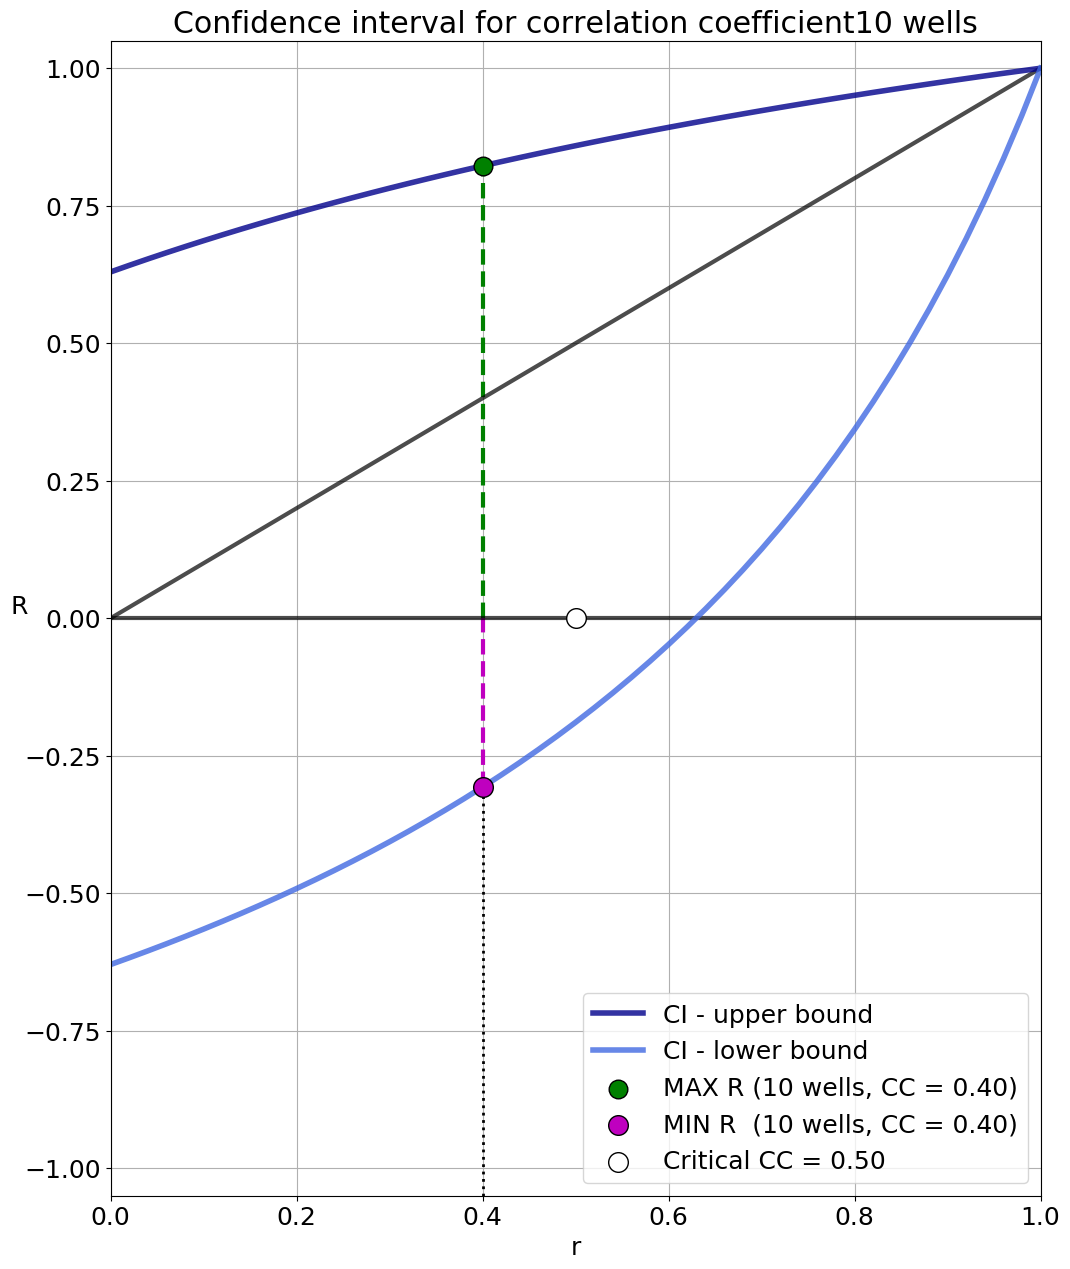

In [8]:
display(rslt)